In [1]:
import polars as pl
from src.features.preprocess import Preprocessor

train_df = pl.read_csv("../dataset/projectA_vehicle_train.csv").drop(
    "posting_date", "id"
)
val_df = pl.read_csv("../dataset/projectA_vehicle_val.csv").drop("posting_date", "id")
test_df = pl.read_csv("../dataset/projectA_vehicle_test.csv").drop("posting_date", "id")


In [2]:
# configs

# 新しい設定システムを使用してデフォルト設定を取得
from src.config.default_config import get_default_config


# デフォルト設定を取得
config = get_default_config()

# 異常検知用に価格の境界を調整（外れ値を除去しない）_config,
config.price_lower_bound = 0
config.price_upper_bound = float("inf")
config.remove_outliers_val = (False,)

# Preprocessorを作成
preprocessor = Preprocessor(**config.to_dict())
print("Preprocessor created with default config for anomaly detection!")
print(f"Price bounds: {config.price_lower_bound} - {config.price_upper_bound}")
print(f"Remove outliers: {config.remove_outliers_val}")

Preprocessor created with default config for anomaly detection!
Price bounds: 0 - inf
Remove outliers: (False,)


In [35]:
train_df_preprocessed, val_df_preprocessed, test_df_preprocessed = preprocessor.run(
    train_df, val_df, test_df
)

outlier_threshold = 45_000
outlier_expr = (pl.col("price") > outlier_threshold).alias("is_outlier")

train_df_preprocessed = train_df_preprocessed.with_columns(outlier_expr)
val_df_preprocessed = val_df_preprocessed.with_columns(outlier_expr)
test_df_preprocessed = test_df_preprocessed.with_columns(outlier_expr)


# サンプリング：外れ値の5倍の数の正常データをサンプリング
n_outliers = train_df_preprocessed.filter(pl.col("is_outlier")).shape[0]
train_df_sampled_negative = train_df_preprocessed.filter(~pl.col("is_outlier")).sample(
    n=n_outliers * 10, seed=42
)
train_df_sampled = pl.concat(
    [
        train_df_sampled_negative,
        train_df_preprocessed.filter(pl.col("is_outlier")),
    ]
)

train_df_sampled.shape

(2695, 27)

In [36]:
# outlier 予測 lightgbm
import lightgbm as lgb

# データセット
train_dataset = lgb.Dataset(
    train_df_preprocessed.drop("price", "is_outlier").to_pandas(),
    label=train_df_preprocessed["is_outlier"].to_pandas(),
)

val_dataset = lgb.Dataset(
    val_df_preprocessed.drop("price", "is_outlier").to_pandas(),
    label=val_df_preprocessed["is_outlier"].to_pandas(),
)

test_dataset = lgb.Dataset(
    test_df_preprocessed.drop("price", "is_outlier").to_pandas(),
    label=test_df_preprocessed["is_outlier"].to_pandas(),
)

# モデルのパラメータ
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
}

# モデルの学習
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=100,
    valid_sets=[train_dataset, val_dataset],
    valid_names=["train", "val"],
    # early_stopping_rounds=10,
    # verbose_eval=10,
)

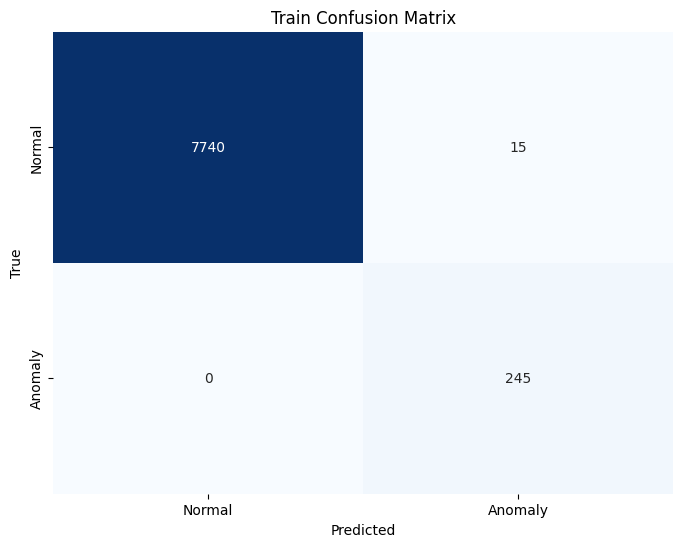

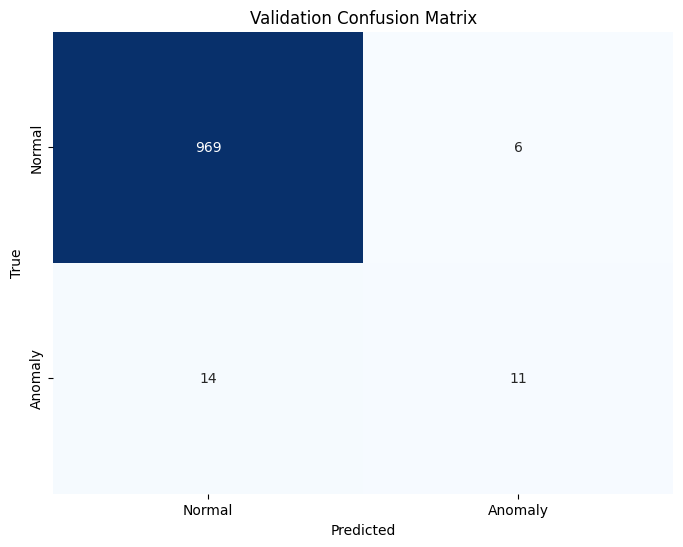

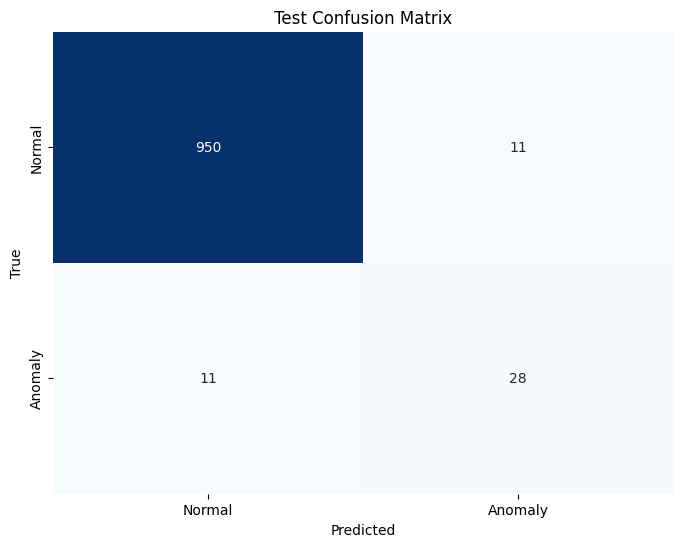

In [37]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# metrics
# 評価指標の計算
y_pred_train = model.predict(
    train_df_preprocessed.drop("price", "is_outlier").to_pandas()
)
y_pred_val = model.predict(val_df_preprocessed.drop("price", "is_outlier").to_pandas())
y_pred_test = model.predict(
    test_df_preprocessed.drop("price", "is_outlier").to_pandas()
)

# 閾値を0.5に設定してバイナリ分類
threshold = 0.20
y_pred_train_binary = (y_pred_train > threshold).astype(int)
y_pred_val_binary = (y_pred_val > threshold).astype(int)
y_pred_test_binary = (y_pred_test > threshold).astype(int)


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Normal", "Anomaly"],
        yticklabels=["Normal", "Anomaly"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


# プロット
plot_confusion_matrix(
    train_df_preprocessed["is_outlier"].to_pandas(),
    y_pred_train_binary,
    title="Train Confusion Matrix",
)
plot_confusion_matrix(
    val_df_preprocessed["is_outlier"].to_pandas(),
    y_pred_val_binary,
    title="Validation Confusion Matrix",
)
plot_confusion_matrix(
    test_df_preprocessed["is_outlier"].to_pandas(),
    y_pred_test_binary,
    title="Test Confusion Matrix",
)

In [38]:
# 結果の分析
from sklearn.metrics import classification_report

# 分類レポートの表示
print("Train Classification Report:")
print(
    classification_report(
        train_df_preprocessed["is_outlier"].to_pandas(),
        y_pred_train_binary,
        target_names=["Normal", "Anomaly"],
    )
)
print("Validation Classification Report:")
print(
    classification_report(
        val_df_preprocessed["is_outlier"].to_pandas(),
        y_pred_val_binary,
        target_names=["Normal", "Anomaly"],
    )
)
print("Test Classification Report:")
print(
    classification_report(
        test_df_preprocessed["is_outlier"].to_pandas(),
        y_pred_test_binary,
        target_names=["Normal", "Anomaly"],
    )
)

Train Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      7755
     Anomaly       0.94      1.00      0.97       245

    accuracy                           1.00      8000
   macro avg       0.97      1.00      0.98      8000
weighted avg       1.00      1.00      1.00      8000

Validation Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       975
     Anomaly       0.65      0.44      0.52        25

    accuracy                           0.98      1000
   macro avg       0.82      0.72      0.76      1000
weighted avg       0.98      0.98      0.98      1000

Test Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       961
     Anomaly       0.72      0.72      0.72        39

    accuracy                           0.98      1000
   macro avg       0.85      0.85    

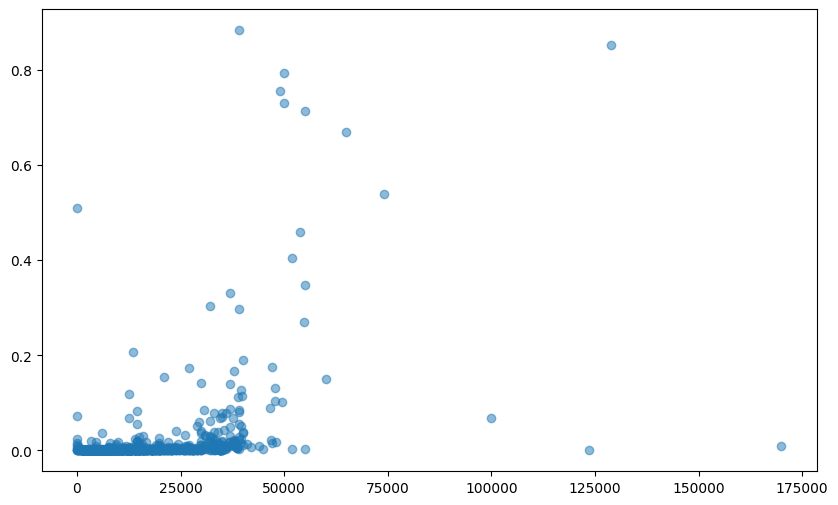

In [39]:
val_price = val_df_preprocessed["price"].to_numpy()

# 価格の分布をプロット
plt.figure(figsize=(10, 6))
plt.scatter(x=val_price, y=y_pred_val, alpha=0.5)

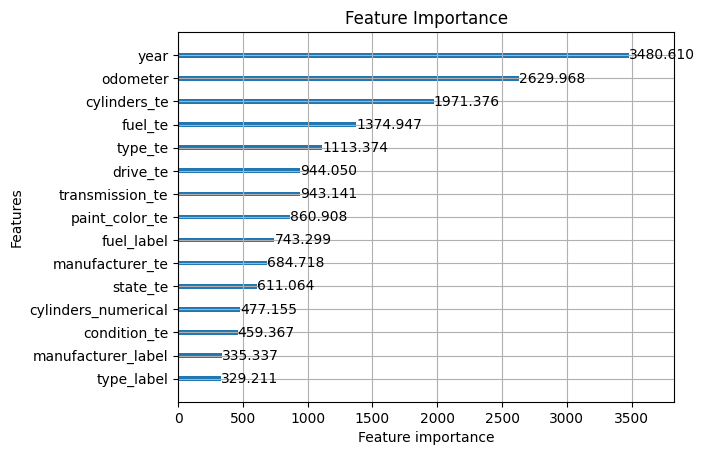

In [40]:
# 特徴量重要度
lgb.plot_importance(model, max_num_features=15, importance_type="gain")
plt.title("Feature Importance")
plt.show()